Filename: ../data/fits/PROMISE-Q1-8micron-filled-v0_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   (120000, 12000)   float32   


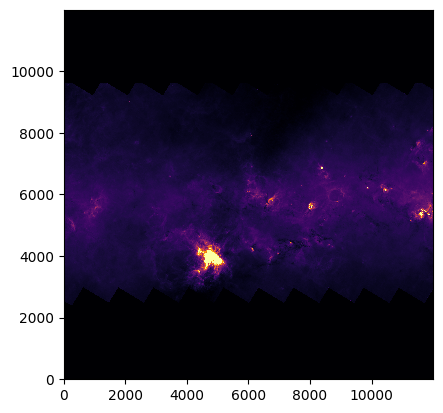

In [2]:
from script.cloud_detection import *
from astropy.io import fits
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch
from tqdm import tqdm

FITS_PATH = '../data/fits/PROMISE-Q1-8micron-filled-v0_3.fits'
# FITS_PATH = '../cnn/fits_for_annotation/box(50316.355, 6033.3671, 234.3168, 178.3296, 0.0).fits'

XSIZE = 12000
YSIZE = 12000
X = 70000
Y = 0

# Open currimg and display info using memmap to not load the whole image into memory
imageHDU = fits.open(FITS_PATH, memmap=True, mode='denywrite')
imageHDU.info()

# Get display image as Numpy Array called data
data = np.array(imageHDU[0].data[Y:Y+YSIZE, X:X+XSIZE], dtype=np.float32) # type: ignore
imageHDU.close() # Close the file

plt.style.use({"image.origin": "lower", "image.interpolation": "nearest"})
cmap1 = ListedColormap(['none', 'white'])

# Display data
plt.imshow(data, cmap='inferno', vmin=0, vmax=500) #nipy_spectral, inferno, plasma, magma, viridis <- all good

In [3]:
def remove_background_fourier_mod(data, radius=10):
    """
    Remove background from image using fourier transform as a filter
    """
    # create kernel
    SIZE = data.shape

    # create it using Gaussian2DKernel
    mask1 = np.float32(
        Gaussian2DKernel(
            x_stddev=radius, y_stddev=radius, x_size=SIZE[1], y_size=SIZE[0]
        ).array
    )
    mask1 = mask1 / np.max(mask1)

    # high pass kernel = 1 - low pass kernel
    mask2 = (1 - mask1).clip(0, 1)

    # high pass first
    fft_shift = np.fft.fftshift(np.fft.fft2(data, axes=(0, 1)))
    fft_masked_high = np.multiply(fft_shift, mask2)
    img_high_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_masked_high)))
    data_clipped = data - img_high_pass

    # fourier transform
    fft_shift = np.fft.fftshift(np.fft.fft2(data_clipped, axes=(0, 1)))

    fft_masked_low = np.multiply(fft_shift, mask1)
    fft_masked_high = np.multiply(fft_shift, mask2)

    img_high_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_masked_high)))
    img_low_pass = np.abs(np.fft.ifft2(np.fft.ifftshift(fft_masked_low)))

    # remove low pass and high pass from original
    diff = data_clipped - img_low_pass - img_high_pass
    diff = diff - np.min(diff)  # normalize to 0

    return diff

100%|██████████| 4/4 [35:48<00:00, 537.11s/it]


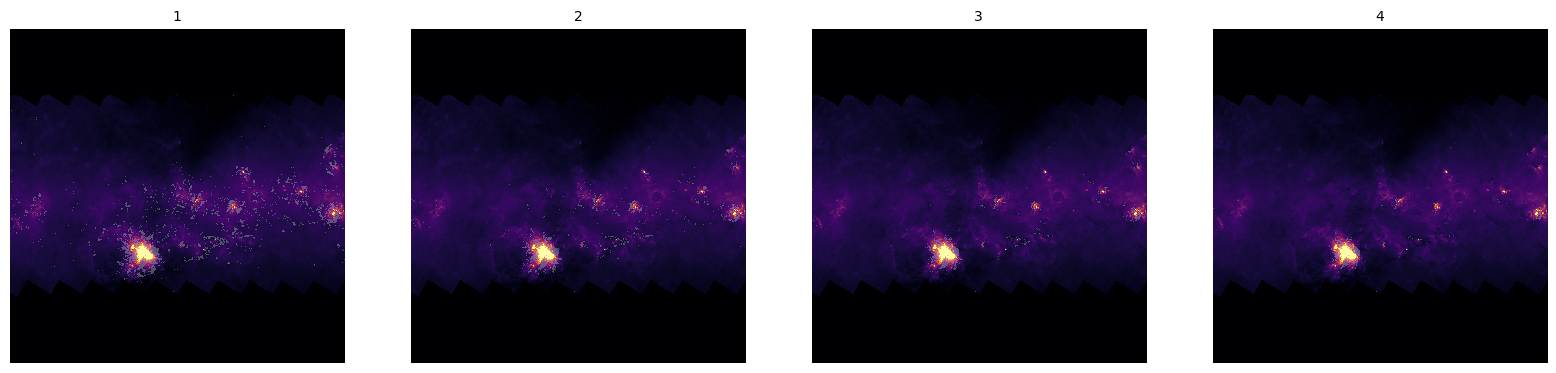

In [4]:
the_range = np.arange(1, 5, 1)
# the_range = np.arange(15,30,5)

fig = plt.figure(figsize=(25, 25))

# radius = 2.5
# thresh = 2.2

for pos, variab in tqdm(enumerate(the_range), total=len(the_range)):
    gauss = remove_background_fourier_mod(data, radius=15)
    mean, median, stddev = sigma_clipped_stats(gauss, sigma=5)
    threshold = mean - variab * stddev
    # threshold = np.mean(gauss) - variab * np.std(gauss)
    mask = np.where(gauss < threshold, True, False)
    # group pixels into labels
    labels, nlabels = scipy.ndimage.label(mask)
    # sum the areas of mask with labels
    dust_areas = np.array(scipy.ndimage.sum(mask, labels, range(0, nlabels + 1)))
    # remove small clouds
    mask_small = dust_areas > 1
    # remove clouds in overlap zone
    mask_overlap = np.ones(mask.shape, dtype=bool)
    mask_overlap[data.shape[0]: data.shape[0], 0: data.shape[1]] = False
    mask_overlap[0: data.shape[0], data.shape[1]: data.shape[1]] = False
    labels_outside_overlap = np.unique(mask_overlap * labels)
    # remove clouds touching the edges of processed image
    mask_edge = np.zeros(mask.shape, dtype=bool)
    mask_edge[0:1, :] = True
    mask_edge[:, 0:1] = True
    mask_edge[data.shape[0] - 1: data.shape[0], :] = True
    mask_edge[:, data.shape[1] - 1: data.shape[1]] = True
    labels_touching_edge = np.unique(mask_edge * labels)
    # remove clouds touching the black border
    objects_first = scipy.ndimage.find_objects(labels)
    masked_data = mask * (data - 1) + 1
    for cloud in range(0, nlabels):
        if (not np.all(masked_data[objects_first[cloud]]) or not (cloud + 1) in labels_outside_overlap or (cloud + 1) in labels_touching_edge):
            mask_small[cloud + 1] = False
    # remove small clouds and edge clouds
    remove_small_clouds = mask_small[labels.ravel()].reshape(labels.shape)
    ax = fig.add_subplot((len(the_range) + 1) // 5 + 1, 5, pos + 1)
    ax.imshow(data, cmap='inferno', vmin=0, vmax=500)
    ax.imshow(remove_small_clouds, cmap=cmap1, alpha=0.3)
    ax.set_title(variab, fontsize=10)
    ax.axis('off')